# Parcial 3: Luis Alejandro Baena Marín

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.interpolate import splrep, BSpline, CubicSpline
from scipy.special import gammainc
from scipy.optimize import brentq
from scipy.stats import norm
from numpy import prod, round, abs, array
import matplotlib.pyplot as plt
from sklearn import datasets
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import math

# Establece la semilla para la generación de números aleatorios
np.random.seed(1)
x = np.random.normal(size=100, loc=2)
y = np.random.normal(size=100, loc=5)

# Función que calcula una funció de un conjunto de datos
def T(x):
  return mean(x)

# Función para calcular la media aritmética de un arreglo
def mean(x) -> float:
  return sum(x)/len(x)

# Función que calcula la media cuadrática (RMS) de un arreglo
def sq_mean(x) -> float:
  return np.sqrt(sum(x**2)/len(x))

# Función para calcular la media geométrica
def geo_mean(x) -> float:
  return (np.prod(x))**(1/len(x))

# Función para calcular la media ponderada de un arreglo, dada una lista de pesos
def w_mean(w, x) -> float:
  if np.round(sum(w),3) != 1.000:
    raise ValueError("Weights must sum to 1")
  return sum((x*w))

# Función para calcular la media truncada, que elimina el porcentaje 'alpha' de los valores extremos
def trim_mean(x, alpha) -> float:
  if alpha >= 0.5 or alpha <= 0:
    raise ValueError("Alpha must be less than 0.5 and greater than 0")
  p = (alpha/2)*len(x)
  return np.mean(np.sort(x)[int(p):-int(p)])

# Función que calcula la mediana de un conjunto de datos
def median(x):
  n = len(x)
  x = sorted(x)
  if n % 2 == 1:
    return x[(n+1)//2-1]
  else:
    return (x[n//2] + x[n//2-1])/2

# Función para calcular la desviación estándar (corregida)
def sd(x):
  x_bar = sum(x)/len(x)
  return ((sum((x-x_bar)**2)/(len(x)-1))**(1/2))

# Función que calcula la desviación absoluta mediana (MAD)
def mad(x, k = 1/0.6745):
  x_tilde = median(x)
  return k*median(np.abs(x-x_tilde))

# Coeficiente de corrección calculado como la relación entre la desviación estándar y el MAD
md = mad(x, k=1)
k = sd(x)/md

# Función que calcula la covarianza entre dos conjuntos de datos
def cov(x, y):
  if len(x) == len(y):
    x_bar = mean(x)
    y_bar = mean(y)
    n = len(x)
    return(sum((x-x_bar)*(y-y_bar))/(n-1))
  else:
    return("Los vectores tienen que tener el mismo largo")

# Función que calcula la covarianza robusta usando medianas
def com(x, y):
  x_median = median(x)
  y_median = median(y)
  return(median((x-x_median)*(y-y_median)))

# Función que calcula el coeficiente de correlación de Pearson
def corr_pearson(x, y):
  return(cov(x, y)/(sd(x)*sd(y)))

# Función que calcula el coeficiente de correlación robusto usando MAD
def corr_com(x, y):
  return(com(x, y)/(mad(x, k=1)*mad(y, k=1)))

# Función para obtener el ranking de los valores de un conjunto de datos
def rank(x):
  x_rank2 = []
  x_sort = sorted(x)
  for i in range(len(x)):
    x_rank2.append(x_sort.index(x[i]) + 1)
  return(array(x_rank2))

# Función que calcula el coeficiente de correlación de Spearman
def rho_spearman(x, y):
  n = len(x)
  return(1-((6*sum((rank(x) - rank(y))**2))/(n*((n**2)-1))))

# Función que calcula el coeficiente de correlación de Kendall
def corr_kendall(x,y):
    if len(x) != len(y):
        raise ValueError("Arguments have unequal length")
    c = 0
    d = 0
    new_x, new_y = zip(*sorted(zip(x, y)))
    for i in range(len(x)):
        for j in range(i+1,len(x)):
            if new_y[i] <= new_y[j]:
                c+=1
            else:
                d+=1
    return (c-d)/(c+d)

# Función que calcula el estimador T-barra usando Jackknife
def t_bar(data, estimator, robust):
    estimations = []
    for i in range(len(data)):
        newlist = data.copy()
        del newlist[i]
        estimations.append(estimator(newlist))
    if robust:
        return np.median(estimations)
    return np.mean(estimations)

# Función que calcula el sesgo de Jackknife
def bias_jackknife(data, estimator, robust=False):
    data = list(data)
    mean_t = t_bar(data, estimator, robust)
    return (len(data)-1) * (mean_t - estimator(data))

# Función que calcula un estimador Jackknife robusto o no
def jackknife_estimator_especifico(data, estimator, robust=False):
    data = np.array(data)
    T_data = estimator(data)
    T_vector = np.empty(len(data))

    for i in range(len(data)):
        T_excluded = estimator(np.delete(data, i))
        T_vector[i] = len(data) * T_data - (len(data) - 1) * T_excluded

    if robust:
        return np.median(T_vector), T_vector
    return np.mean(T_vector), T_vector

# Función que calcula varios estimadores Jackknife
def jackknife_estimator_general(x, T):
  Tn = T(x)
  n = len(x)
  T_tildes = []
  for i in range(len(x)):
    lista = list(x)
    lista.pop(i)
    T_tildes.append(n*Tn-(n-1)*T(np.array(lista)))

  T_tildes = np.array(T_tildes)
  T_jack = mean(T_tildes)

  s2_tilde = sum((T_tildes - mean(T_tildes))**2)/(n-1)
  Var_T_jack = s2_tilde/n

  return ({"T_tildes": T_tildes, "Estimador": T_jack, "Var_estimador": Var_T_jack})

# Método Bootstrap a un estimador para obtener su distribución, estimación promedio y varianza
def bootstrap_estimator(x, T, B=500):
    n = len(x)
    x = np.array(x)
    T_boots = []

    for _ in range(B):
        x_resample = np.random.choice(x, size=n)
        T_boots.append(T(x_resample))

    T_boots = np.array(T_boots)

    T_boot = mean(T_boots)
    var_boot = mean((T_boots - mean(T_boots))**2)
    return {"distro": T_boots, "Estimador": T_boot, "VarEstimator": var_boot}

# Función de distribución empírica (ECDF) de un conjunto de datos
def ECDF(x):
    n = len(x)
    x = sorted(x)
    ECDF_list = []
    for i in range(len(x)):
        ECDF_list.append(i/n)
    return [x, ECDF_list]

# Calcula el percentil de un conjunto de datos
def percentile(data, percent):
    if percent < 0 or percent > 100:
        raise ValueError("Percent debe estar entre 0 y 100")

    data = np.sort(data)
    index = (len(data) - 1) * (percent / 100)
    lower = int(np.floor(index))
    upper = int(np.ceil(index))

    if lower == upper:
        return data[lower]
    else:
        return data[lower] + (data[upper] - data[lower]) * (index - lower)

# Calcula el intervalo de confianza del 95% de un estimador basado en la distribución bootstrap
def confidence_interval(bootstrap_dist, confidence=0.95):
    lower_percentile = (1 - confidence) / 2
    upper_percentile = 1 - lower_percentile
    ci_lower = percentile(bootstrap_dist, lower_percentile * 100)
    ci_upper = percentile(bootstrap_dist, upper_percentile * 100)
    return (ci_lower, ci_upper)

# Weighted least squares (WLS)
def WLS(x, y, w = None):
  if (len(x.shape) == 1):
    x = x.reshape(-1,1)

  # Matriz de diseño: matrix "x" aumentada con columna de unos
  X = np.concatenate([np.ones((len(x),1)), x], axis = 1)
  n, p = X.shape
  if w is None:
    w = np.eye(n)

  left = np.linalg.inv(np.matmul(np.matmul(np.transpose(X), w), X))
  right = np.matmul(np.matmul(np.transpose(X), w), y)
  beta = np.matmul(left, right)

  return beta




'''print(f"Mean: {mean(x)}")
print(f"Square mean: {sq_mean(x)}")
print(f"Geometric mean: {geo_mean(x)}")
w=np.random.uniform(1,100,size=len(x)); w/=sum(w);
print(f"Weighted mean: {w_mean(w, x)}")
alpha = 0.2
print(f"Alpha: {alpha}. Trim mean: {trim_mean(x, alpha)}")
print(f"Mediana (Q2): {median(x)}")
print(f"Standard Deviation: {sd(x)}")
print(f"MAD: {mad(x, k=1)}")
print(f"Coeficiente de corrección: {k}")
print(f"Pearson: {corr_pearson(x,y)}")
print(f"Spearman: {rho_spearman(x,y)}")
print(f"Kendall: {corr_kendall(x,y)}")
print(f"Bias Jackknife: {bias_jackknife(x, T)}")
print(f"Jackknife especifico 1: {jackknife_estimator_especifico(x, T, robust=True)[0]}")
print(f"Jackknife general 2: {jackknife_estimator_general(x, T)['Estimador']}")
boots = bootstrap_estimator(x, T)
print(f"Estimador Boostrap para sd: {round(boots['Estimador'],4)}")
print(f"Varianza del estimador: {round(boots['VarEstimator'],4)}")
#plt.hist(boots["distro"])
#plt.plot(ECDF(x)[0], ECDF(x)[1])
median_boot = bootstrap_estimator(x, T)
ci_lower, ci_upper = confidence_interval(median_boot["distro"])
print(f"I.C 95%: [{round(ci_lower, 3)}, {round(ci_upper, 3)}]")
#x = np.random.multivariate_normal(mean = [0,0,0], cov = [[1,0,0],[0,1,0],[0,0,1]],size=n)
#e = np.random.normal(loc = 0, scale = 1.2, size = n)
#y = 1 + 2*x[:,0] + 3*x[:,1] + 4*x[:,2] + e
print(f"Coeficcients WLS: {WLS(x,y)}")'''

'print(f"Mean: {mean(x)}")\nprint(f"Square mean: {sq_mean(x)}")\nprint(f"Geometric mean: {geo_mean(x)}")\nw=np.random.uniform(1,100,size=len(x)); w/=sum(w);\nprint(f"Weighted mean: {w_mean(w, x)}")\nalpha = 0.2\nprint(f"Alpha: {alpha}. Trim mean: {trim_mean(x, alpha)}")\nprint(f"Mediana (Q2): {median(x)}")\nprint(f"Standard Deviation: {sd(x)}")\nprint(f"MAD: {mad(x, k=1)}")\nprint(f"Coeficiente de corrección: {k}")\nprint(f"Pearson: {corr_pearson(x,y)}")\nprint(f"Spearman: {rho_spearman(x,y)}")\nprint(f"Kendall: {corr_kendall(x,y)}")\nprint(f"Bias Jackknife: {bias_jackknife(x, T)}")\nprint(f"Jackknife especifico 1: {jackknife_estimator_especifico(x, T, robust=True)[0]}")\nprint(f"Jackknife general 2: {jackknife_estimator_general(x, T)[\'Estimador\']}")\nboots = bootstrap_estimator(x, T)\nprint(f"Estimador Boostrap para sd: {round(boots[\'Estimador\'],4)}")\nprint(f"Varianza del estimador: {round(boots[\'VarEstimator\'],4)}")\n#plt.hist(boots["distro"])\n#plt.plot(ECDF(x)[0], ECDF(x)[1]

# Punto 1

In [31]:
n = 1000
std_dev = 0.8

# Cedula: 1023628877

X1_sizes = [n // 4, n // 2, n // 4]
X2_sizes = [2 * n // 5, n // 5, 2 * n // 5]
X3_sizes = [4 * n // 7, 2 * n // 7, n // 7]

def generate_sample(sizes, means, std_dev, seed):
    np.random.seed(seed)
    samples = [np.random.normal(loc=mean, scale=std_dev, size=size) for mean, size in zip(means, sizes)]
    return np.concatenate(samples)

# Generar muestras
means = [3, 6, 9]
X1 = generate_sample(X1_sizes, means, std_dev, 1023)
X2 = generate_sample(X2_sizes, means, std_dev, 8877)
X3 = generate_sample(X3_sizes, means, std_dev, 17)

### Item 1

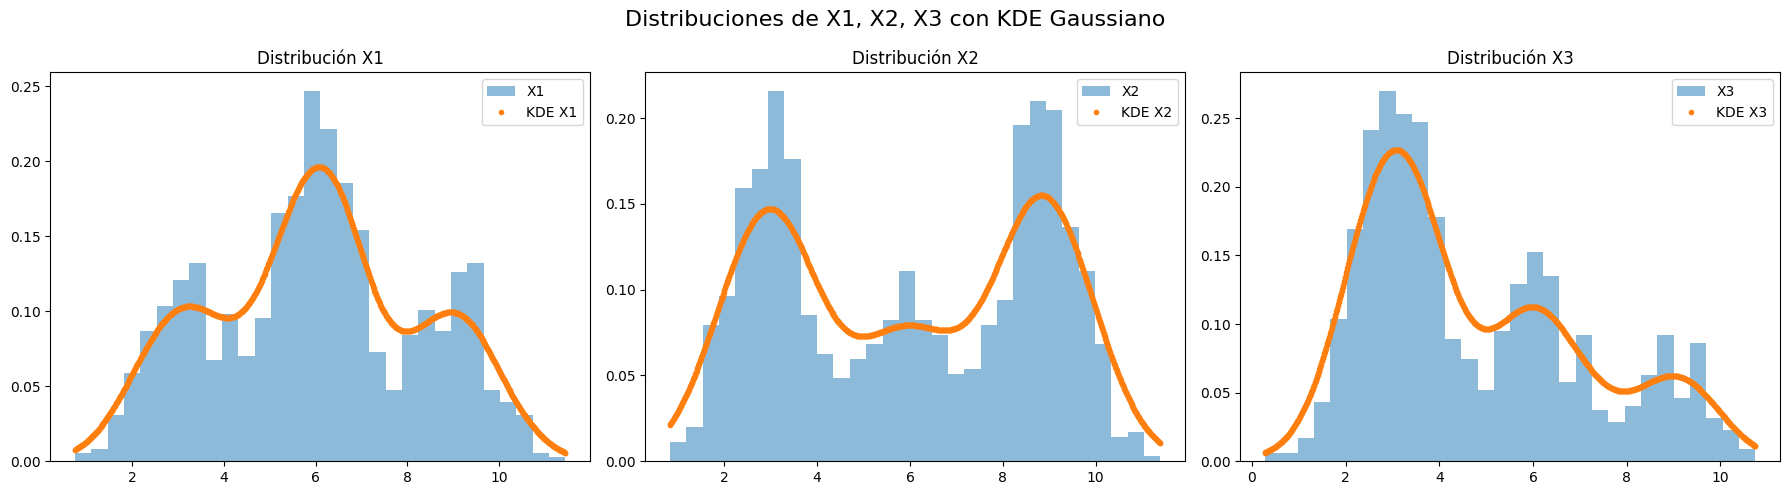

In [32]:
# Bin-width
def KDE(X):
  sigma_gorro = min(np.std(X), (np.quantile(X, 0.75) - np.quantile(X, 0.25))/1.34)
  n = len(X)
  h = 1.06*sigma_gorro/(n**(1/5))
  x = np.linspace(min(X), max(X), 1000)
  fx = []
  for i in range(len(x)):
    K = norm.pdf((x[i]-X)/h)
    fx.append((1/n)*sum((1/h)*K))
  return([x, np.array(fx)])

# Crear gráfico
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# X1
axs[0].hist(X1, bins=30, density=True, alpha=0.5, label="X1")
x1, fx1 = KDE(X1)
axs[0].plot(x1, fx1, '.', label="KDE X1")
axs[0].set_title("Distribución X1")
axs[0].legend()

# X2
axs[1].hist(X2, bins=30, density=True, alpha=0.5, label="X2")
x2, fx2 = KDE(X2)
axs[1].plot(x2, fx2, '.', label="KDE X2")
axs[1].set_title("Distribución X2")
axs[1].legend()

# X3
axs[2].hist(X3, bins=30, density=True, alpha=0.5, label="X3")
x3, fx3 = KDE(X3)
axs[2].plot(x3, fx3, '.', label="KDE X3")
axs[2].set_title("Distribución X3")
axs[2].legend()

# Mostrar
fig.suptitle('Distribuciones de X1, X2, X3 con KDE Gaussiano', fontsize=16)
plt.tight_layout()
plt.show()

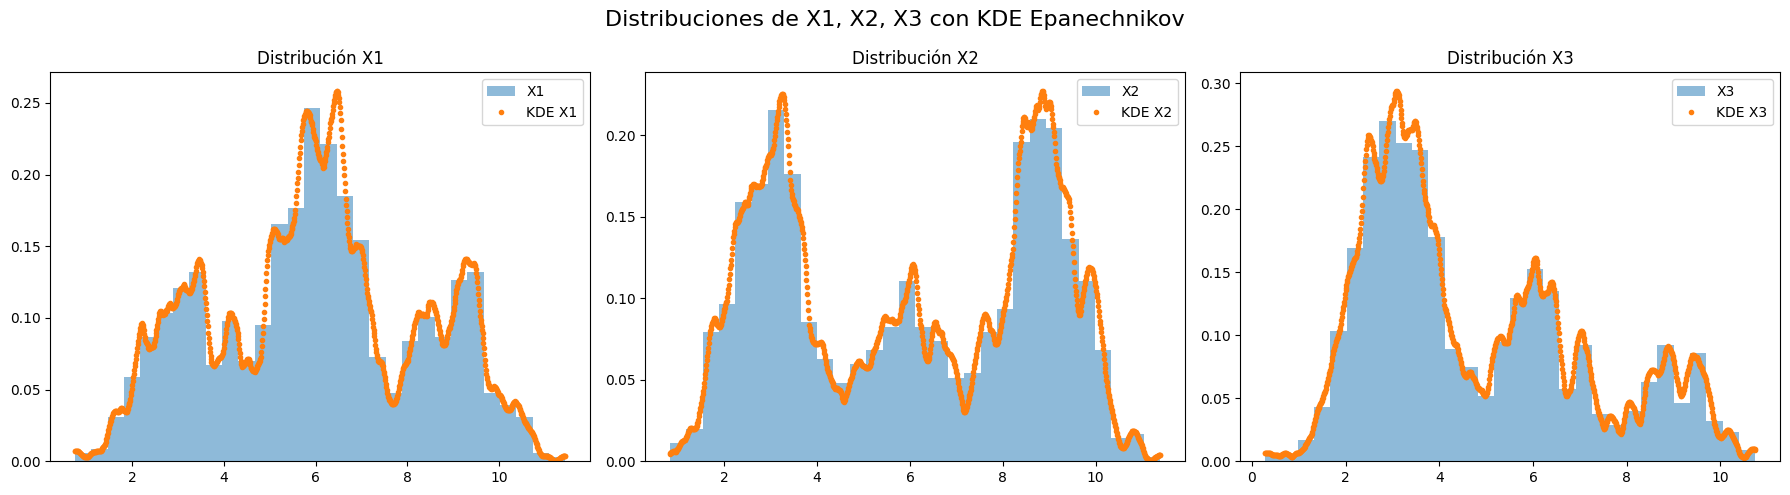

In [33]:
def epanechnikov(x):
  K = np.zeros(len(x))
  K[abs(x)<1] = (3/4)*(1 - (x[abs(x)<1])**2)
  return(K)

def KDE_epanechnikov(data, bandwidth=0.2):
    x_vals = np.linspace(min(data), max(data), 1000)
    y_vals = np.zeros(len(x_vals))
    for xi in data:
        y_vals += epanechnikov((x_vals - xi) / bandwidth)
    return x_vals, y_vals / (len(data) * bandwidth)

# Crear gráfico
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# X1
axs[0].hist(X1, bins=30, density=True, alpha=0.5, label="X1")
x1, fx1 = KDE_epanechnikov(X1)
axs[0].plot(x1, fx1, '.', label="KDE X1")
axs[0].set_title("Distribución X1")
axs[0].legend()

# X2
axs[1].hist(X2, bins=30, density=True, alpha=0.5, label="X2")
x2, fx2 = KDE_epanechnikov(X2)
axs[1].plot(x2, fx2, '.', label="KDE X2")
axs[1].set_title("Distribución X2")
axs[1].legend()

# X3
axs[2].hist(X3, bins=30, density=True, alpha=0.5, label="X3")
x3, fx3 = KDE_epanechnikov(X3)
axs[2].plot(x3, fx3, '.', label="KDE X3")
axs[2].set_title("Distribución X3")
axs[2].legend()

# Mostrar
fig.suptitle('Distribuciones de X1, X2, X3 con KDE Epanechnikov', fontsize=16)
plt.tight_layout()
plt.show()

### Item 2

In [ ]:
# Función para calcular la CDF empírica H_hat(r) usando los pivotes bootstrap
def bootstrap_pivot_cdf(bootstrap_pivots, r):
    B = len(bootstrap_pivots)
    count = sum(1 for pivot in bootstrap_pivots if pivot <= r)  # Contar cuántos pivotes son <= r
    return count / B  # Aproximación de la CDF empírica

# Calcula los pivotes bootstrap
def bootstrap_pivotal_interval(x, T, B=500, alpha=0.05):
    n = len(x)
    theta_n = T(x)

    T_boots = []
    for _ in range(B):
        x_resample = np.random.choice(x, size=n, replace=True)
        T_boots.append(T(x_resample))

    T_boots = np.array(T_boots)
    R_boots = T_boots - theta_n

    # Cuantiles de los pivotes bootstrap
    r_lower = percentile(R_boots+theta_n, (alpha / 2) * 100)
    r_upper = percentile(R_boots+theta_n, (1 - alpha / 2) * 100)

    # Intervalo pivotal usando los pivotes y cuantiles
    a = 2 * theta_n - r_upper
    b = 2 * theta_n - r_lower

    return a, b

In [ ]:
# Intervalo de confianza pivotal para X1
ci_lower_X1, ci_upper_X1 = bootstrap_pivotal_interval(X1, mean, B=500, alpha=0.05)
print(f"Intervalo de confianza pivotal para la media de X1: [{round(ci_lower_X1, 3)}, {round(ci_upper_X1, 3)}]")

# Intervalo de confianza pivotal para X2
ci_lower_X2, ci_upper_X2 = bootstrap_pivotal_interval(X2, mean, B=500, alpha=0.05)
print(f"Intervalo de confianza pivotal para la media de X2: [{round(ci_lower_X2, 3)}, {round(ci_upper_X2, 3)}]")

# Intervalo de confianza pivotal para X3
ci_lower_X3, ci_upper_X3 = bootstrap_pivotal_interval(X3, mean, B=500, alpha=0.05)
print(f"Intervalo de confianza pivotal para la media de X3: [{round(ci_lower_X3, 3)}, {round(ci_upper_X3, 3)}]")

Intervalo de confianza pivotal para la media de X1: [5.876, 6.144]
Intervalo de confianza pivotal para la media de X2: [5.814, 6.161]
Intervalo de confianza pivotal para la media de X3: [4.581, 4.858]


### Item 3

In [ ]:
# Mann-Whitney U
def mann_whitney_u_test(x1, x2):
    # Combinar los datos
    datos = sorted(list(zip(np.concatenate([x1, x2]), ['group1']*len(x1) + ['group2']*len(x2))))
    rank = np.array(range(1, len(datos) + 1))

    T1 = sum(rank[np.array(list(zip(*datos))[1]) == "group1"])
    T2 = sum(rank[np.array(list(zip(*datos))[1]) == "group2"])

    n1 = len(x1)
    n2 = len(x2)

    U1 = n1 * n2 + (n1 * (n1 + 1)) / 2 - T1
    U2 = n1 * n2 + (n2 * (n2 + 1)) / 2 - T2

    U = min(U1, U2)
    mu_U = n1 * n2 / 2
    sigma_U = np.sqrt((n1 * n2 * (n1 + n2 + 1)) / 12)

    Z = (U - mu_U) / sigma_U
    return U, Z

# Comparaciones de Mann-Whitney U
results = {}

# X1 vs. X2
U_X1_X2, Z_X1_X2 = mann_whitney_u_test(X1, X2)
results['X1 vs. X2'] = (U_X1_X2, Z_X1_X2)

# X1 vs. X3
U_X1_X3, Z_X1_X3 = mann_whitney_u_test(X1, X3)
results['X1 vs. X3'] = (U_X1_X3, Z_X1_X3)

# X2 vs. X3
U_X2_X3, Z_X2_X3 = mann_whitney_u_test(X2, X3)
results['X2 vs. X3'] = (U_X2_X3, Z_X2_X3)

# Imprimir resultados
for comparison, (U, Z) in results.items():
    print(f"{comparison}: U = {U}, Z = {Z}")

X1 vs. X2: U = 498087.0, Z = -0.14814331162631067
X1 vs. X3: U = 340656.0, Z = -12.280627742365153
X2 vs. X3: U = 376234.0, Z = -9.521317798080132


Al comparar los resultados, se observa una clara discrepancia entre las variables:

- Para \(X1\) y \(X2\), ambos intervalos de confianza se superponen significativamente, lo que sugiere que no hay evidencia suficiente para rechazar la hipótesis nula de que las dos medias son iguales. Esto concuerda con el valor de \(Z\) (-0.148), indicando una diferencia no significativa.

- En contraste, el intervalo de confianza de \(X3\) no se superpone con los de \(X1\) y \(X2\), lo que respalda los resultados de las pruebas de Mann-Whitney. Los resultados para las comparaciones \(X1\) vs. \(X3\) da un Z = -12.281 y \(X2\) vs. \(X3\) con un Z = -9.521 sugieren diferencias significativas.

- Además, el gráfico de densidad muestra que las distribuciones entre las tres variables no se parecen.

# Punto 2

### Item 1

In [2]:
# !pip install palmerpenguins

from palmerpenguins import load_penguins

penguins = load_penguins()

In [3]:
penguins = penguins[['species', 'flipper_length_mm', 'bill_length_mm']]
penguins

,species,flipper_length_mm,bill_length_mm
0,Adelie,181.0,39.1
1,Adelie,186.0,39.5
2,Adelie,195.0,40.3
3,Adelie,NaN,NaN
4,Adelie,193.0,36.7
...,...,...,...
339,Chinstrap,207.0,55.8
340,Chinstrap,202.0,43.5
341,Chinstrap,193.0,49.6
342,Chinstrap,210.0,50.8


In [4]:
# Imputar valores faltantes
penguins['flipper_length_mm'] = penguins['flipper_length_mm'].fillna(penguins['flipper_length_mm'].median())
penguins['species'] = penguins['species'].fillna(penguins['species'].mode()[0])

# Eliminar filas con valores nulos
penguins = penguins.dropna(subset=["bill_length_mm"])
penguins

<ipython-input-4-33a47a155719>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penguins['flipper_length_mm'] = penguins['flipper_length_mm'].fillna(penguins['flipper_length_mm'].median())
<ipython-input-4-33a47a155719>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penguins['species'] = penguins['species'].fillna(penguins['species'].mode()[0])


,species,flipper_length_mm,bill_length_mm
0,Adelie,181.0,39.1
1,Adelie,186.0,39.5
2,Adelie,195.0,40.3
4,Adelie,193.0,36.7
5,Adelie,190.0,39.3
...,...,...,...
339,Chinstrap,207.0,55.8
340,Chinstrap,202.0,43.5
341,Chinstrap,193.0,49.6
342,Chinstrap,210.0,50.8


In [5]:
# Crear variables binarias para la especie
penguins_dummies = pd.get_dummies(penguins['species'], prefix='species')
penguins = pd.concat([penguins, penguins_dummies], axis=1)
'''penguins['species_binary'] = penguins['species'].map({
    'Adelie': [0, 0],
    'Chinstrap': [0, 1],
    'Gentoo': [1, 0]
})'''

penguins = penguins.drop(columns=['species'])
penguins

,flipper_length_mm,bill_length_mm,species_Adelie,species_Chinstrap,species_Gentoo
0,181.0,39.1,True,False,False
1,186.0,39.5,True,False,False
2,195.0,40.3,True,False,False
4,193.0,36.7,True,False,False
5,190.0,39.3,True,False,False
...,...,...,...,...,...
339,207.0,55.8,False,True,False
340,202.0,43.5,False,True,False
341,193.0,49.6,False,True,False
342,210.0,50.8,False,True,False


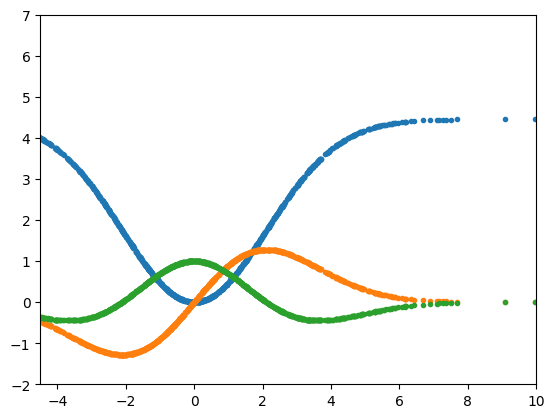

In [6]:
# Welsch (27)

# Funcion de perdida
def welsch_rho(errores, c = 2.9846):
  rho = []
  for e in errores:
      rho.append((c**2)*(1/2)*(1-np.exp(-(e/c)**2)))

  return(np.array(rho))

# Funcion de influencia
def welsch_psi(errores, c = 2.9846):
  psi = []
  for e in errores:
      psi.append(e*np.exp(-(e/c)**2))

  return(np.array(psi))

# Funcion de penalizacion
def welsch_w(errores, c = 2.9846):
  w = []
  for e in errores:
    w.append(np.exp(-(e/c)**2)-((2*e**2*np.exp(-(e/c)**2))/(c**2)))

  return(np.array(w))

e = np.random.normal(loc = 0, scale = 3, size = 1000)
rhos = welsch_rho(e)
psis = welsch_psi(e)
ws = welsch_w(e)
plt.xlim(-4.5,10)
plt.ylim(-2,7)

plt.plot(e, rhos, '.')
plt.plot(e, psis, '.')
plt.plot(e, ws, '.')

In [7]:
# Matriz de diseño
def OLS(X, y):
  '''
  Esta funcion calcula los coeficientes de regresion usando la
  solucion matricial via OLS del modelo de Regresion Lineal.
    Input:
      y: variable respuesta
      X: Matriz de diseño
    Output:
      betas: vector de coeficientes de regresion
  '''

  betas = np.linalg.inv(np.transpose(X)@X)@np.transpose(X)@y
  return(betas)

# Estimador M
def M_estimator(X, y, i = True, tol = 1e-10, iter_max = 10000):
  '''
    Esta función implementa un estimador M robusto para la regresión lineal.
    Se basa en un enfoque iterativo que ajusta los coeficientes para minimizar
    la influencia de datos atípicos.

    Input:
        X: Matriz de diseño (incluyendo el intercepto)
        y: variable respuesta
        i: indicador para imprimir el número de iteraciones (por defecto: True)
        tol: tolerancia para la convergencia del estimador (por defecto: 1e-10)
        iter_max: número máximo de iteraciones permitidas (por defecto: 10000)

    Output:
        beta: vector de coeficientes de regresión ajustados
  '''

  beta_inicial = OLS(X, y)
  e = y - X@beta_inicial
  sigma = mad(e)
  e_s = e/sigma
  w_ii = welsch_psi(e_s)/e_s
  iter_count = 0

  while True:
    iter_count += 1
    W = np.diag(w_ii)
    beta = (np.linalg.inv(X.T @ W @ X) @ X.T @ W @ y)

    # Comprobar la convergencia
    if np.sqrt(sum((beta-beta_inicial)**2)) < tol:
      break

    if (iter_count == iter_max):
      break

    beta_inicial = beta
    e = y - X@beta
    sigma = mad(e)
    e_s = e/sigma
    w_ii = welsch_psi(e_s)/e_s

  if i: print(f"Número de iteraciones: {iter_count}")
  return(beta)

In [8]:
# Usar solo 2 columnas binarias para evitar redundancia
x1 = np.array(penguins["flipper_length_mm"])
x2 = np.array(penguins["species_Adelie"])
x3 = np.array(penguins["species_Gentoo"])
x4 = np.array(penguins["species_Chinstrap"])
y = np.array(penguins["bill_length_mm"])
welsch1 = np.column_stack([np.ones(len(y)), x1, x2, x3])

params = M_estimator(welsch1, y)
print("Estimated parameters:", params)

Número de iteraciones: 16
Estimated parameters: [ 5.35846251  0.22150631 -8.61804778 -6.0248602 ]


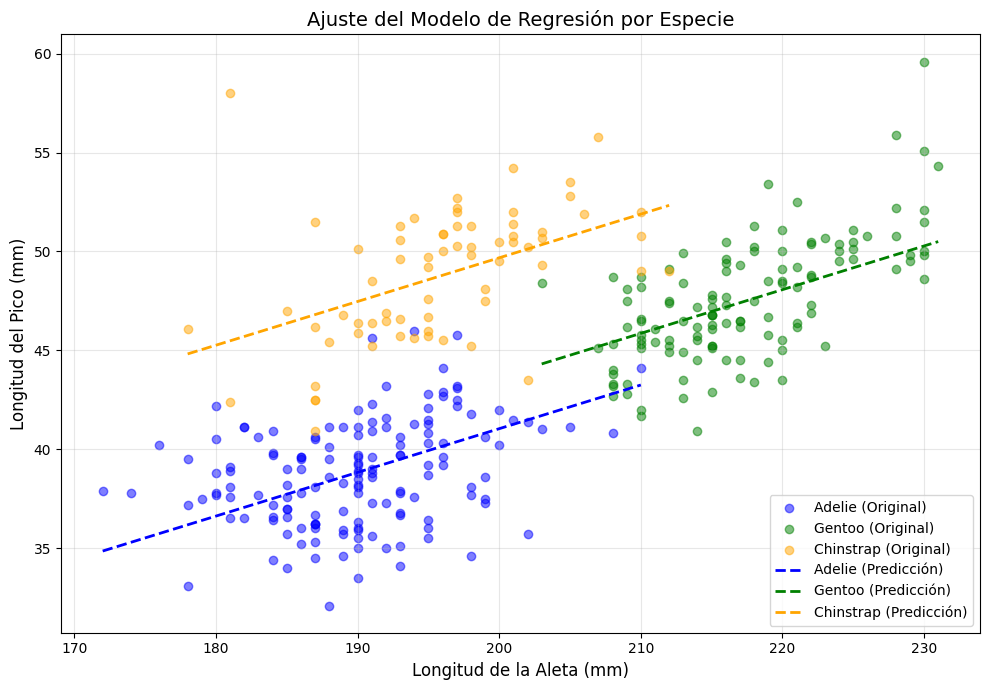

In [25]:
# Realizar predicciones
predictions = np.dot(welsch1, params)

plt.figure(figsize=(10, 7))

species = ['Adelie', 'Gentoo', 'Chinstrap']
colors = ['blue', 'green', 'orange']

# Graficar los datos originales por especie
plt.scatter(x1[x2 == 1], y[x2 == 1], color=colors[0], alpha=0.5, label='Adelie (Original)')
plt.scatter(x1[x3 == 1], y[x3 == 1], color=colors[1], alpha=0.5, label='Gentoo (Original)')
plt.scatter(x1[x4 == 1], y[x4 == 1], color=colors[2], alpha=0.5, label='Chinstrap (Original)')

# Graficar las predicciones por especie
for i, (color, specie_mask) in enumerate(zip(colors, [x2, x3, x4])):
    # Índices ordenados para una línea suave
    sort_idx = np.argsort(x1[specie_mask == 1])
    x1_sorted = x1[specie_mask == 1][sort_idx]
    predictions_sorted = predictions[specie_mask == 1][sort_idx]

    # Línea de predicción
    plt.plot(x1_sorted, predictions_sorted, color=color, linestyle='--', linewidth=2, label=f'{species[i]} (Predicción)')

# Configuración de la gráfica
plt.xlabel('Longitud de la Aleta (mm)', fontsize=12)
plt.ylabel('Longitud del Pico (mm)', fontsize=12)
plt.title('Ajuste del Modelo de Regresión por Especie', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

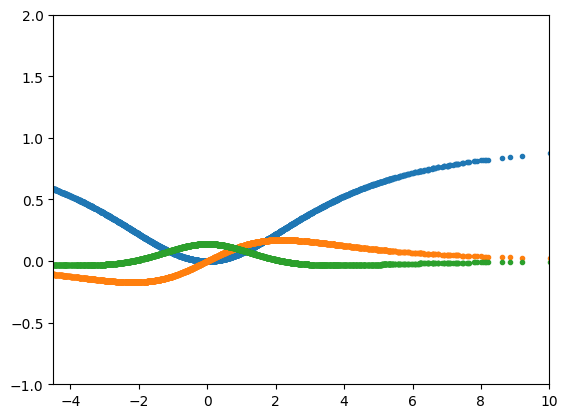

In [26]:
# Lorentzian (23)

# Funcion de perdida
def lorentzian_rho(errores, c = 2.678):
  rho = []
  for e in errores:
      rho.append(1-(1/(1+((e**2)/(2*c**2)))))

  return(np.array(rho))

# Funcion de influencia
def lorentzian_psi(errores, c = 2.678):
  psi = []
  for e in errores:
      psi.append(e/(c**2*((1+(e**2)/(2*c**2)))**2))

  return(np.array(psi))

# Funcion de penalizacion
def lorentzian_w(errores, c = 2.678):
  w = []
  for e in errores:
    w.append(((4*c**2)*(2*c**2-3*e**2))/((2*c**2+e**2)**3))

  return(np.array(w))

e = np.random.normal(loc = 0, scale = 3, size = 3000)
rhos = lorentzian_rho(e)
psis = lorentzian_psi(e)
ws = lorentzian_w(e)
plt.xlim(-4.5,10)
plt.ylim(-1,2)

plt.plot(e, rhos, '.')
plt.plot(e, psis, '.')
plt.plot(e, ws, '.')

In [27]:
# Estimador M
def M_estimator(X, y, i = True, tol = 1e-10, iter_max = 10000):
  '''
    Esta función implementa un estimador M robusto para la regresión lineal.
    Se basa en un enfoque iterativo que ajusta los coeficientes para minimizar
    la influencia de datos atípicos.

    Input:
        X: Matriz de diseño (incluyendo el intercepto)
        y: variable respuesta
        i: indicador para imprimir el número de iteraciones (por defecto: True)
        tol: tolerancia para la convergencia del estimador (por defecto: 1e-10)
        iter_max: número máximo de iteraciones permitidas (por defecto: 10000)

    Output:
        beta: vector de coeficientes de regresión ajustados
  '''

  beta_inicial = OLS(X, y)
  e = y - X@beta_inicial
  sigma = mad(e)
  e_s = e/sigma
  w_ii = lorentzian_psi(e_s)/e_s
  iter_count = 0

  while True:
    iter_count += 1
    W = np.diag(w_ii)
    beta = (np.linalg.inv(X.T @ W @ X) @ X.T @ W @ y)

    # Comprobar la convergencia
    if np.sqrt(sum((beta-beta_inicial)**2)) < tol:
      break

    if (iter_count == iter_max):
      break

    beta_inicial = beta
    e = y - X@beta
    sigma = mad(e)
    e_s = e/sigma
    w_ii = lorentzian_psi(e_s)/e_s

  if i: print(f"Número de iteraciones: {iter_count}")
  return(beta)

In [28]:
# Usar solo 2 columnas binarias para evitar redundancia
x1 = np.array(penguins["flipper_length_mm"])
x2 = np.array(penguins["species_Adelie"])
x3 = np.array(penguins["species_Gentoo"])
x4 = np.array(penguins["species_Chinstrap"])
y = np.array(penguins["bill_length_mm"])
lorentzian1 = np.column_stack([np.ones(len(y)), x1, x2, x3])

params = M_estimator(lorentzian1, y)
print("Estimated parameters:", params)

Número de iteraciones: 17
Estimated parameters: [ 5.49811783  0.22090153 -8.63887162 -6.02846172]


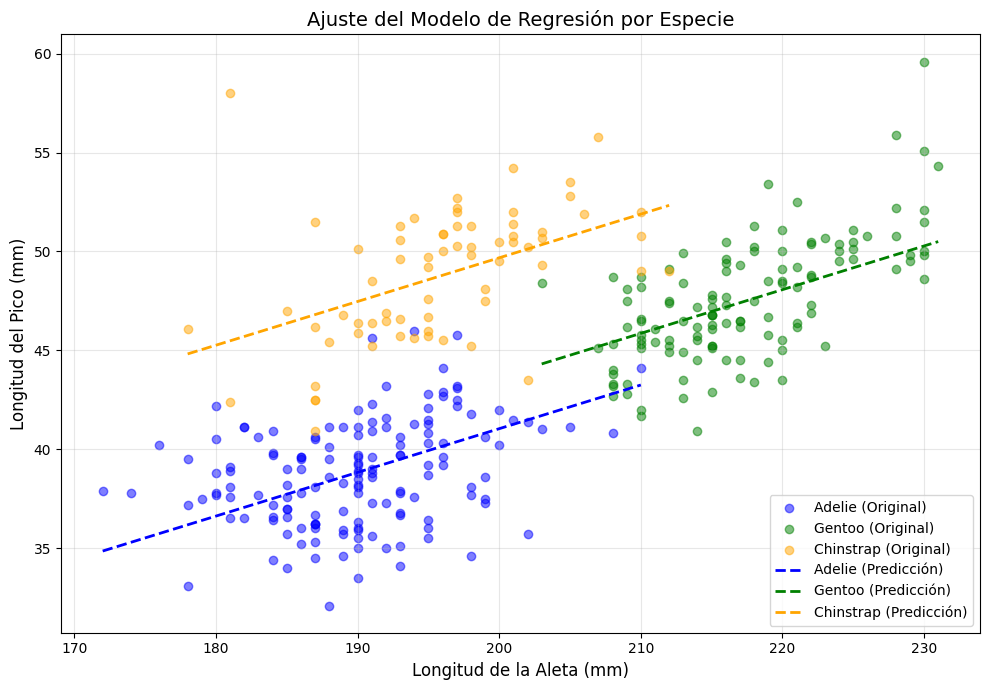

In [29]:
# Realizar predicciones
predictions = np.dot(lorentzian1, params)

plt.figure(figsize=(10, 7))

species = ['Adelie', 'Gentoo', 'Chinstrap']
colors = ['blue', 'green', 'orange']

# Graficar los datos originales por especie
plt.scatter(x1[x2 == 1], y[x2 == 1], color=colors[0], alpha=0.5, label='Adelie (Original)')
plt.scatter(x1[x3 == 1], y[x3 == 1], color=colors[1], alpha=0.5, label='Gentoo (Original)')
plt.scatter(x1[x4 == 1], y[x4 == 1], color=colors[2], alpha=0.5, label='Chinstrap (Original)')

# Graficar las predicciones por especie
for i, (color, specie_mask) in enumerate(zip(colors, [x2, x3, x4])):
    # Índices ordenados para una línea suave
    sort_idx = np.argsort(x1[specie_mask == 1])
    x1_sorted = x1[specie_mask == 1][sort_idx]
    predictions_sorted = predictions[specie_mask == 1][sort_idx]

    # Línea de predicción
    plt.plot(x1_sorted, predictions_sorted, color=color, linestyle='--', linewidth=2, label=f'{species[i]} (Predicción)')

# Configuración de la gráfica
plt.xlabel('Longitud de la Aleta (mm)', fontsize=12)
plt.ylabel('Longitud del Pico (mm)', fontsize=12)
plt.title('Ajuste del Modelo de Regresión por Especie', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Item 2

In [46]:
def bootstrap_coefficient(X, y, n_iterations):
    n_samples = len(y)
    coefficients = np.zeros(n_iterations)

    for i in range(n_iterations):
        indices = np.random.choice(np.arange(n_samples), size=n_samples, replace=True)
        X_bootstrap = X[indices]
        y_bootstrap = y[indices]

        coeffs = M_estimator(X_bootstrap, y_bootstrap, i = False)
        coefficients[i] = coeffs[1]

    return coefficients

# Realizar bootstrapping para estimar el coeficiente
n_iterations = 10000
bootstrap_coefficients_welsch = bootstrap_coefficient(welsch1, y, n_iterations)

n_iterations = 10000
bootstrap_coefficients_lorentzian = bootstrap_coefficient(lorentzian1, y, n_iterations)

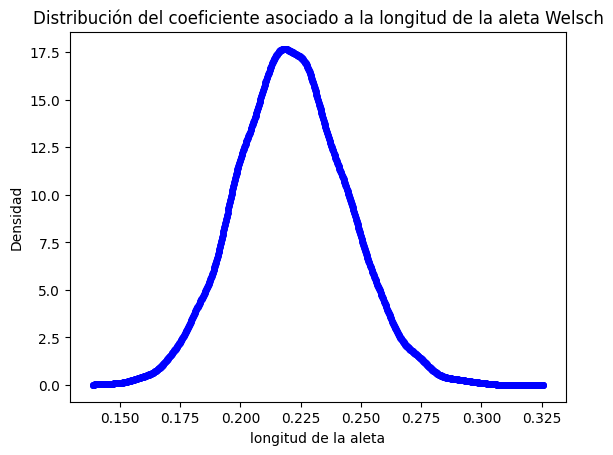

In [47]:
x1, fx1 = KDE(bootstrap_coefficients_welsch)

# Crear gráfico
plt.figure()
plt.plot(x1, fx1, color='blue', linestyle='-', marker='o', markersize=4)
plt.title("Distribución del coeficiente asociado a la longitud de la aleta Welsch", fontsize=12)
plt.xlabel("longitud de la aleta", fontsize=10)
plt.ylabel("Densidad", fontsize=10)
plt.show()

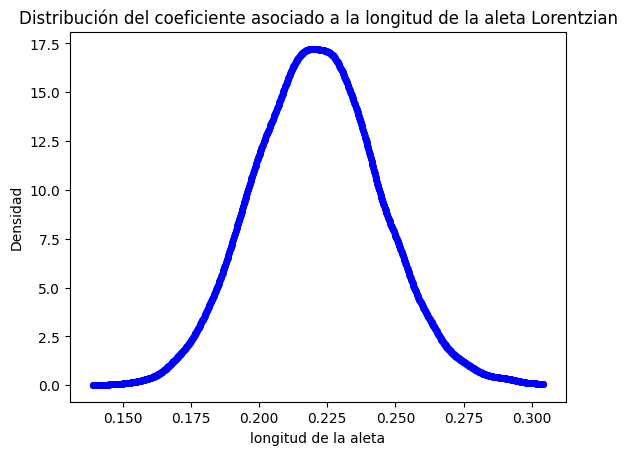

In [48]:
x1, fx1 = KDE(bootstrap_coefficients_lorentzian)

# Crear gráfico
plt.figure()
plt.plot(x1, fx1, color='blue', linestyle='-', marker='o', markersize=4)
plt.title("Distribución del coeficiente asociado a la longitud de la aleta Lorentzian", fontsize=12)
plt.xlabel("longitud de la aleta", fontsize=10)
plt.ylabel("Densidad", fontsize=10)
plt.show()

Con la distribución acumulada empírica

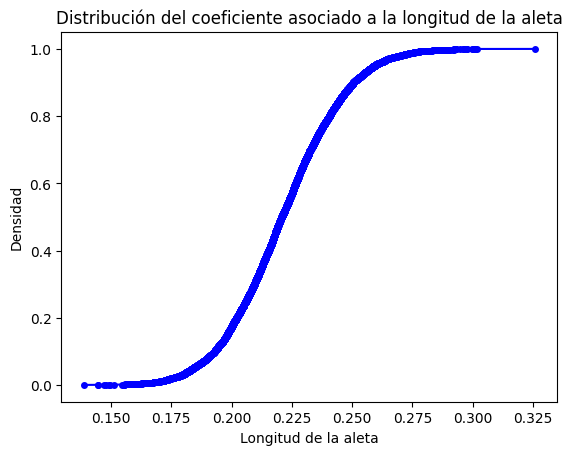

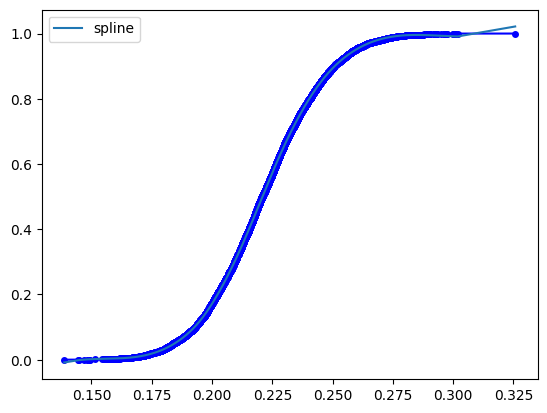

In [61]:
from scipy.interpolate import BSpline

# Distribución del coeficiente asociado a la longitud de la aleta
x1, fx1 = ECDF(bootstrap_coefficients_welsch)

plt.figure()
plt.plot(x1, fx1, color='blue', linestyle='-', marker='o', markersize=4)
plt.title("Distribución del coeficiente asociado a la longitud de la aleta", fontsize=12)
plt.xlabel("Longitud de la aleta", fontsize=10)
plt.ylabel("Densidad", fontsize=10)
plt.show()

# Ajuste de la curva usando BSpline
plt.plot(x1, fx1, color='blue', linestyle='-', marker='o', markersize=4)
tck_s = splrep(x1, fx1, s=0.025)
plt.plot(x1, BSpline(*tck_s)(x1), '-', label=f'spline')
plt.legend()
plt.show()

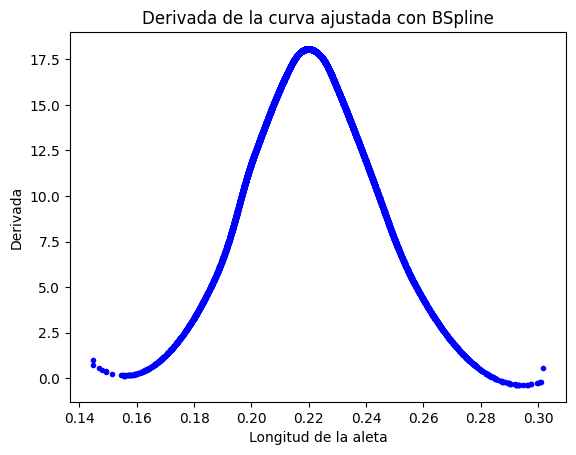

In [62]:
# Derivada de la curva ajustada
f = BSpline(*tck_s)(x1)

derivada = []
for i in range(1, len(x1)-1):
  dif1 = (f[i] - f[i-1])/(x1[i]-x1[i-1])
  dif2 = (f[i] - f[i+1])/(x1[i]-x1[i+1])
  derivada.append(0.5*dif1+0.5*dif2)

plt.plot(x1[1:len(x1)-1], derivada, '.', color='blue')
plt.title("Derivada de la curva ajustada con BSpline", fontsize=12)
plt.xlabel("Longitud de la aleta", fontsize=10)
plt.ylabel("Derivada", fontsize=10)
plt.show()

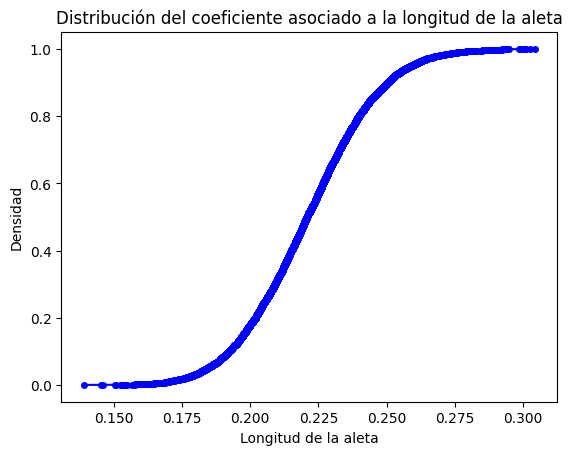

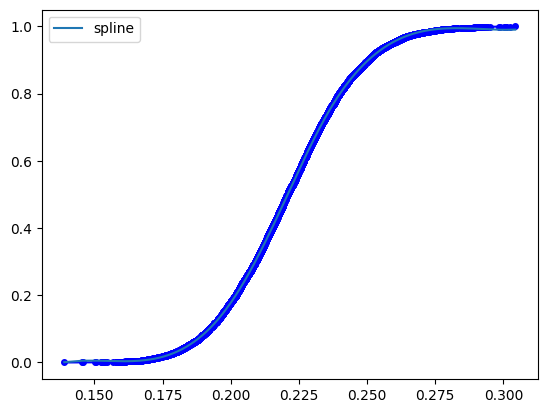

In [63]:
# Distribución del coeficiente asociado a la longitud de la aleta
x1, fx1 = ECDF(bootstrap_coefficients_lorentzian)

plt.figure()
plt.plot(x1, fx1, color='blue', linestyle='-', marker='o', markersize=4)
plt.title("Distribución del coeficiente asociado a la longitud de la aleta", fontsize=12)
plt.xlabel("Longitud de la aleta", fontsize=10)
plt.ylabel("Densidad", fontsize=10)
plt.show()

# Ajuste de la curva usando BSpline
plt.plot(x1, fx1, color='blue', linestyle='-', marker='o', markersize=4)
tck_s = splrep(x1, fx1, s=0.025)
plt.plot(x1, BSpline(*tck_s)(x1), '-', label=f'spline')
plt.legend()
plt.show()

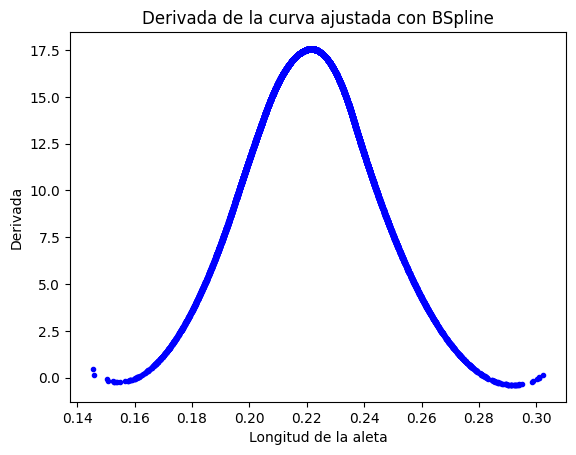

In [64]:
# Derivada de la curva ajustada
f = BSpline(*tck_s)(x1)

derivada = []
for i in range(1, len(x1)-1):
  dif1 = (f[i] - f[i-1])/(x1[i]-x1[i-1])
  dif2 = (f[i] - f[i+1])/(x1[i]-x1[i+1])
  derivada.append(0.5*dif1+0.5*dif2)

plt.plot(x1[1:len(x1)-1], derivada, '.', color='blue')
plt.title("Derivada de la curva ajustada con BSpline", fontsize=12)
plt.xlabel("Longitud de la aleta", fontsize=10)
plt.ylabel("Derivada", fontsize=10)
plt.show()